In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

In [2]:
# Load the preprocessed data
file_path = 'cleaned_online_retail_data.csv'  # Path to the exported .csv
data = pd.read_csv(file_path)

# Inspect the first few rows
print("Initial Data:")
print(data.head())

Initial Data:
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country Day of Week  \
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom     Tuesday   
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom     Tuesday   
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom     Tuesday   
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom     Tuesday   
4  2009-12-01 07:45:00   1.25      13085.0  United Kingdom     Tuesday   

   Time of Day  Total Revenue  
0            7           83.4  
1            7           81.0  
2            7          

In [3]:
# 1) Select Relevant Features for Clustering
features = ['Total Revenue', 'Quantity', 'Time of Day']

# Clean data: Handle missing values and filter out negative quantities or revenues
data = data.dropna(subset=features)
data = data[(data['Total Revenue'] >= 0) & (data['Quantity'] > 0)]

# Cap outliers at the 99th percentile for robust clustering
for feature in features:
    upper_limit = data[feature].quantile(0.99)
    data = data[data[feature] <= upper_limit]

In [4]:
# 2) Standardize the Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[features])

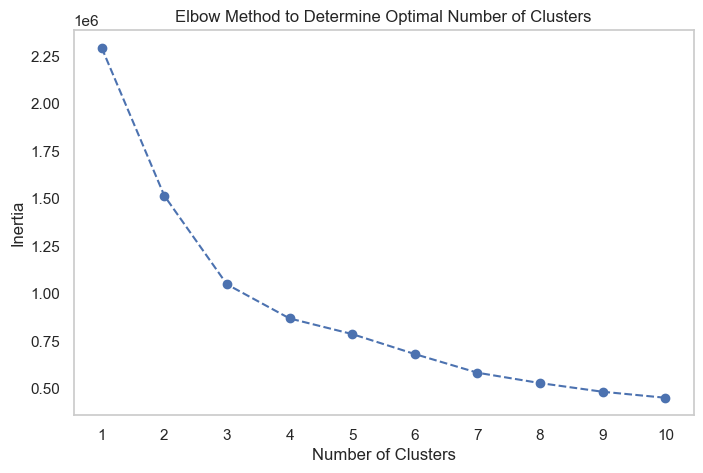

In [5]:
# 3) Determine the Optimal Number of Clusters Using the Elbow Method
inertia = []
range_n_clusters = range(1, 11)

for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, inertia, marker='o', linestyle='--')
plt.title('Elbow Method to Determine Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(range_n_clusters)
plt.grid()
plt.show()

In [6]:
# 4) Apply K-Means with the Optimal Number of Clusters
optimal_k = 3 
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data['Cluster'] = kmeans.fit_predict(X_scaled)

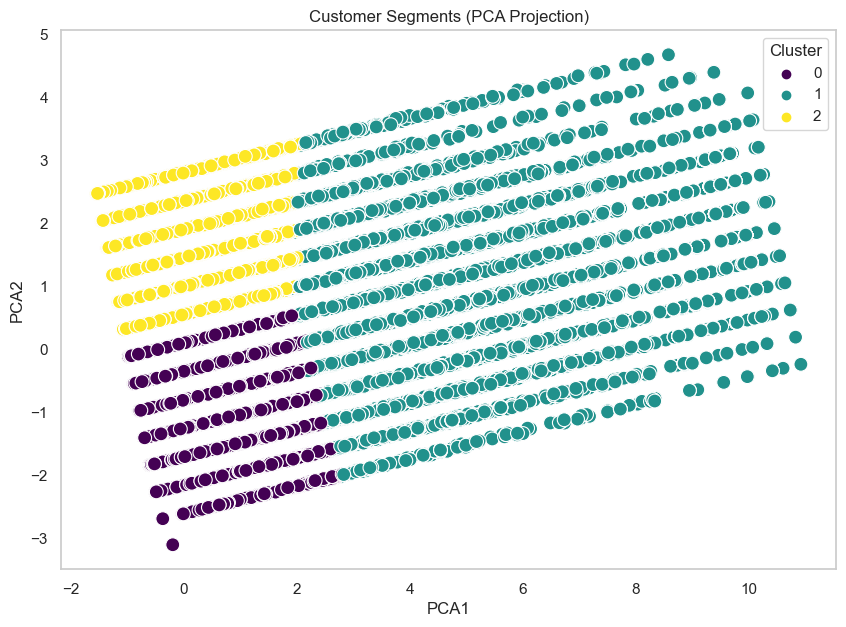

In [7]:
# 5) Analyze and Visualize Clusters
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
data['PCA1'] = X_pca[:, 0]
data['PCA2'] = X_pca[:, 1]

# Scatter Plot of Clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='PCA1',
    y='PCA2',
    hue='Cluster',
    palette='viridis',
    data=data,
    s=100,
)
plt.title('Customer Segments (PCA Projection)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.grid()
plt.show()

In [8]:
# 6) Cluster Profiling
cluster_summary = data.groupby('Cluster')[features].mean()
cluster_summary['Num Customers'] = data['Cluster'].value_counts()
print("Cluster Profiles:")
print(cluster_summary)

Cluster Profiles:
         Total Revenue   Quantity  Time of Day  Num Customers
Cluster                                                      
0            13.597868   7.543855    11.414659         456609
1            86.838213  48.979460    12.233121          38169
2            12.374858   6.869418    15.179453         270021


In [10]:
# 7) Personalized Marketing Suggestions
for cluster, stats in cluster_summary.iterrows():
    print(f"\nCluster {cluster} Marketing Strategy:")
    print(f" - Avg Revenue: £{stats['Total Revenue']:.2f}")
    print(f" - Avg Quantity: {stats['Quantity']:.2f}")
    print(f" - Peak Engagement Time: {stats['Time of Day']:.2f} (Hour)")
    if stats['Total Revenue'] > cluster_summary['Total Revenue'].mean():
        print(" - High Revenue Segment: Consider exclusive discounts or loyalty programs.")
    else:
        print(" - Low Revenue Segment: Recommend popular or budget-friendly products.")


Cluster 0 Marketing Strategy:
 - Avg Revenue: £13.60
 - Avg Quantity: 7.54
 - Peak Engagement Time: 11.41 (Hour)
 - Low Revenue Segment: Recommend popular or budget-friendly products.

Cluster 1 Marketing Strategy:
 - Avg Revenue: £86.84
 - Avg Quantity: 48.98
 - Peak Engagement Time: 12.23 (Hour)
 - High Revenue Segment: Consider exclusive discounts or loyalty programs.

Cluster 2 Marketing Strategy:
 - Avg Revenue: £12.37
 - Avg Quantity: 6.87
 - Peak Engagement Time: 15.18 (Hour)
 - Low Revenue Segment: Recommend popular or budget-friendly products.
